# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/recon_max_sparse_top_{N}_v2-2.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/recon_max_sparse_ablated_top_{N}_v2-2.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

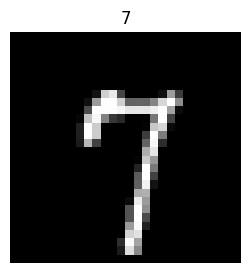

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [15]:
min_loss = 0.011
max_loss = 0.021
step = 0.001
loss_factors = np.arange(min_loss, max_loss + step, step)
print(len(loss_factors))

12


In [16]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.011




Epoch 1/20
  Train Loss: 1.0792
  SAE Train Loss (hidden one): 8.3558
  SAE Train Loss (hidden two): 1.1222
  Val Loss: 0.6472 | Val Acc: 83.65%
  Saved model with Val Acc: 83.65%


Epoch 2/20
  Train Loss: 0.5535
  SAE Train Loss (hidden one): 0.4286
  SAE Train Loss (hidden two): 0.0940
  Val Loss: 0.4929 | Val Acc: 85.78%
  Saved model with Val Acc: 85.78%


Epoch 3/20
  Train Loss: 0.4594
  SAE Train Loss (hidden one): 0.3944
  SAE Train Loss (hidden two): 0.0771
  Val Loss: 0.4595 | Val Acc: 86.95%
  Saved model with Val Acc: 86.95%


Epoch 4/20
  Train Loss: 0.4287
  SAE Train Loss (hidden one): 0.4082
  SAE Train Loss (hidden two): 0.0662
  Val Loss: 0.4136 | Val Acc: 87.99%
  Saved model with Val Acc: 87.99%


Epoch 5/20
  Train Loss: 0.4158
  SAE Train Loss (hidden one): 0.4540
  SAE Train Loss (hidden two): 0.0596
  Val Loss: 0.4099 | Val Acc: 87.91%


Epoch 6/20
  Train Loss: 0.4069
  SAE Train Loss (hidden one): 0.4232
  SAE Train Loss (hidden two): 0.0554
  Val Loss: 0.4100 | Val Acc: 88.07%
  Saved model with Val Acc: 88.07%


Epoch 7/20
  Train Loss: 0.3987
  SAE Train Loss (hidden one): 0.4155
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.4490 | Val Acc: 86.93%


Epoch 8/20
  Train Loss: 0.3916
  SAE Train Loss (hidden one): 0.4676
  SAE Train Loss (hidden two): 0.0504
  Val Loss: 0.3924 | Val Acc: 88.62%
  Saved model with Val Acc: 88.62%


Epoch 9/20
  Train Loss: 0.3832
  SAE Train Loss (hidden one): 0.4363
  SAE Train Loss (hidden two): 0.0468
  Val Loss: 0.4015 | Val Acc: 88.24%


Epoch 10/20
  Train Loss: 0.3781
  SAE Train Loss (hidden one): 0.4193
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.4220 | Val Acc: 87.62%


Epoch 11/20
  Train Loss: 0.3720
  SAE Train Loss (hidden one): 0.4727
  SAE Train Loss (hidden two): 0.0441
  Val Loss: 0.3852 | Val Acc: 88.89%
  Saved model with Val Acc: 88.89%


Epoch 12/20
  Train Loss: 0.3678
  SAE Train Loss (hidden one): 0.4561
  SAE Train Loss (hidden two): 0.0427
  Val Loss: 0.3994 | Val Acc: 88.43%


Epoch 13/20
  Train Loss: 0.3646
  SAE Train Loss (hidden one): 0.4863
  SAE Train Loss (hidden two): 0.0417
  Val Loss: 0.3816 | Val Acc: 88.91%
  Saved model with Val Acc: 88.91%


Epoch 14/20
  Train Loss: 0.3602
  SAE Train Loss (hidden one): 0.4002
  SAE Train Loss (hidden two): 0.0391
  Val Loss: 0.4105 | Val Acc: 87.83%


Epoch 15/20
  Train Loss: 0.3589
  SAE Train Loss (hidden one): 0.4597
  SAE Train Loss (hidden two): 0.0394
  Val Loss: 0.3976 | Val Acc: 88.58%


Epoch 16/20
  Train Loss: 0.3560
  SAE Train Loss (hidden one): 0.4542
  SAE Train Loss (hidden two): 0.0378
  Val Loss: 0.3776 | Val Acc: 89.09%
  Saved model with Val Acc: 89.09%


Epoch 17/20
  Train Loss: 0.3539
  SAE Train Loss (hidden one): 0.4597
  SAE Train Loss (hidden two): 0.0366
  Val Loss: 0.3678 | Val Acc: 89.39%
  Saved model with Val Acc: 89.39%


Epoch 18/20
  Train Loss: 0.3489
  SAE Train Loss (hidden one): 0.4673
  SAE Train Loss (hidden two): 0.0356
  Val Loss: 0.3731 | Val Acc: 89.29%


Epoch 19/20
  Train Loss: 0.3526
  SAE Train Loss (hidden one): 0.4887
  SAE Train Loss (hidden two): 0.0384
  Val Loss: 0.3739 | Val Acc: 89.19%


Epoch 20/20
  Train Loss: 0.3479
  SAE Train Loss (hidden one): 0.5603
  SAE Train Loss (hidden two): 0.0358
  Val Loss: 0.3852 | Val Acc: 88.85%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 256.11it/s]


Final Test Accuracy: 89.66%
Average Reconstruction Error (Hidden One): 0.1129
Average Reconstruction Error (Hidden Two): 0.0107
Average Non-Zero Features per Image (Hidden One): 31.22
Average Non-Zero Features per Image (Hidden Two): 31.99


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 88.25%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 86.77%

##################################################
Loss factor: 0.012




Epoch 1/20
  Train Loss: 1.0786
  SAE Train Loss (hidden one): 8.3583
  SAE Train Loss (hidden two): 1.1252
  Val Loss: 0.6813 | Val Acc: 81.31%
  Saved model with Val Acc: 81.31%


Epoch 2/20
  Train Loss: 0.5868
  SAE Train Loss (hidden one): 0.4496
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.5208 | Val Acc: 84.14%
  Saved model with Val Acc: 84.14%


Epoch 3/20
  Train Loss: 0.4558
  SAE Train Loss (hidden one): 0.4368
  SAE Train Loss (hidden two): 0.0745
  Val Loss: 0.4391 | Val Acc: 87.24%
  Saved model with Val Acc: 87.24%


Epoch 4/20
  Train Loss: 0.4173
  SAE Train Loss (hidden one): 0.4315
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.3941 | Val Acc: 88.34%
  Saved model with Val Acc: 88.34%


Epoch 5/20
  Train Loss: 0.4005
  SAE Train Loss (hidden one): 0.4493
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.4117 | Val Acc: 87.74%


Epoch 6/20
  Train Loss: 0.3833
  SAE Train Loss (hidden one): 0.4615
  SAE Train Loss (hidden two): 0.0569
  Val Loss: 0.3748 | Val Acc: 88.65%
  Saved model with Val Acc: 88.65%


Epoch 7/20
  Train Loss: 0.3749
  SAE Train Loss (hidden one): 0.4688
  SAE Train Loss (hidden two): 0.0533
  Val Loss: 0.3809 | Val Acc: 88.73%
  Saved model with Val Acc: 88.73%


Epoch 8/20
  Train Loss: 0.3659
  SAE Train Loss (hidden one): 0.4747
  SAE Train Loss (hidden two): 0.0516
  Val Loss: 0.3822 | Val Acc: 88.66%


Epoch 9/20
  Train Loss: 0.3570
  SAE Train Loss (hidden one): 0.4920
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.3810 | Val Acc: 88.85%
  Saved model with Val Acc: 88.85%


Epoch 10/20
  Train Loss: 0.3538
  SAE Train Loss (hidden one): 0.4704
  SAE Train Loss (hidden two): 0.0486
  Val Loss: 0.3735 | Val Acc: 88.88%
  Saved model with Val Acc: 88.88%


Epoch 11/20
  Train Loss: 0.3509
  SAE Train Loss (hidden one): 0.5246
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3718 | Val Acc: 89.09%
  Saved model with Val Acc: 89.09%


Epoch 12/20
  Train Loss: 0.3446
  SAE Train Loss (hidden one): 0.5068
  SAE Train Loss (hidden two): 0.0450
  Val Loss: 0.3539 | Val Acc: 89.58%
  Saved model with Val Acc: 89.58%


Epoch 13/20
  Train Loss: 0.3438
  SAE Train Loss (hidden one): 0.5261
  SAE Train Loss (hidden two): 0.0451
  Val Loss: 0.3672 | Val Acc: 89.26%


Epoch 14/20
  Train Loss: 0.3393
  SAE Train Loss (hidden one): 0.5007
  SAE Train Loss (hidden two): 0.0434
  Val Loss: 0.3679 | Val Acc: 89.39%


Epoch 15/20
  Train Loss: 0.3357
  SAE Train Loss (hidden one): 0.4911
  SAE Train Loss (hidden two): 0.0427
  Val Loss: 0.3598 | Val Acc: 89.37%


Epoch 16/20
  Train Loss: 0.3337
  SAE Train Loss (hidden one): 0.6572
  SAE Train Loss (hidden two): 0.0441
  Val Loss: 0.3487 | Val Acc: 89.59%
  Saved model with Val Acc: 89.59%


Epoch 17/20
  Train Loss: 0.3308
  SAE Train Loss (hidden one): 0.4868
  SAE Train Loss (hidden two): 0.0404
  Val Loss: 0.3588 | Val Acc: 89.38%


Epoch 18/20
  Train Loss: 0.3280
  SAE Train Loss (hidden one): 0.5734
  SAE Train Loss (hidden two): 0.0412
  Val Loss: 0.3506 | Val Acc: 89.69%
  Saved model with Val Acc: 89.69%


Epoch 19/20
  Train Loss: 0.3266
  SAE Train Loss (hidden one): 0.6477
  SAE Train Loss (hidden two): 0.0401
  Val Loss: 0.3501 | Val Acc: 89.42%


Epoch 20/20
  Train Loss: 0.3236
  SAE Train Loss (hidden one): 0.4670
  SAE Train Loss (hidden two): 0.0388
  Val Loss: 0.3582 | Val Acc: 89.18%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 269.36it/s]


Final Test Accuracy: 89.96%
Average Reconstruction Error (Hidden One): 2.2206
Average Reconstruction Error (Hidden Two): 0.0100
Average Non-Zero Features per Image (Hidden One): 31.70
Average Non-Zero Features per Image (Hidden Two): 31.65


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.50%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.29%

##################################################
Loss factor: 0.013000000000000001




Epoch 1/20
  Train Loss: 1.0784
  SAE Train Loss (hidden one): 8.4361
  SAE Train Loss (hidden two): 1.1508
  Val Loss: 0.6820 | Val Acc: 82.45%
  Saved model with Val Acc: 82.45%


Epoch 2/20
  Train Loss: 0.5539
  SAE Train Loss (hidden one): 0.3785
  SAE Train Loss (hidden two): 0.0849
  Val Loss: 0.4925 | Val Acc: 85.95%
  Saved model with Val Acc: 85.95%


Epoch 3/20
  Train Loss: 0.4631
  SAE Train Loss (hidden one): 0.3950
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.4935 | Val Acc: 85.64%


Epoch 4/20
  Train Loss: 0.4351
  SAE Train Loss (hidden one): 0.4341
  SAE Train Loss (hidden two): 0.0660
  Val Loss: 0.4310 | Val Acc: 87.22%
  Saved model with Val Acc: 87.22%


Epoch 5/20
  Train Loss: 0.4128
  SAE Train Loss (hidden one): 0.4931
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.4137 | Val Acc: 87.99%
  Saved model with Val Acc: 87.99%


Epoch 6/20
  Train Loss: 0.4007
  SAE Train Loss (hidden one): 0.4309
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3905 | Val Acc: 88.60%
  Saved model with Val Acc: 88.60%


Epoch 7/20
  Train Loss: 0.3940
  SAE Train Loss (hidden one): 0.3782
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.4228 | Val Acc: 87.94%


Epoch 8/20
  Train Loss: 0.3887
  SAE Train Loss (hidden one): 0.4465
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3999 | Val Acc: 88.26%


Epoch 9/20
  Train Loss: 0.3815
  SAE Train Loss (hidden one): 0.4123
  SAE Train Loss (hidden two): 0.0480
  Val Loss: 0.4106 | Val Acc: 88.09%


Epoch 10/20
  Train Loss: 0.3781
  SAE Train Loss (hidden one): 0.3927
  SAE Train Loss (hidden two): 0.0458
  Val Loss: 0.3976 | Val Acc: 88.51%


Epoch 11/20
  Train Loss: 0.3741
  SAE Train Loss (hidden one): 0.4599
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3921 | Val Acc: 88.68%
  Saved model with Val Acc: 88.68%


Epoch 12/20
  Train Loss: 0.3682
  SAE Train Loss (hidden one): 0.4208
  SAE Train Loss (hidden two): 0.0439
  Val Loss: 0.3948 | Val Acc: 88.47%


Epoch 13/20
  Train Loss: 0.3672
  SAE Train Loss (hidden one): 0.4979
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3856 | Val Acc: 88.80%
  Saved model with Val Acc: 88.80%


Epoch 14/20
  Train Loss: 0.3626
  SAE Train Loss (hidden one): 0.4406
  SAE Train Loss (hidden two): 0.0418
  Val Loss: 0.3788 | Val Acc: 88.95%
  Saved model with Val Acc: 88.95%


Epoch 15/20
  Train Loss: 0.3595
  SAE Train Loss (hidden one): 0.3886
  SAE Train Loss (hidden two): 0.0417
  Val Loss: 0.3909 | Val Acc: 88.67%


Epoch 16/20
  Train Loss: 0.3556
  SAE Train Loss (hidden one): 0.4417
  SAE Train Loss (hidden two): 0.0403
  Val Loss: 0.3773 | Val Acc: 89.21%
  Saved model with Val Acc: 89.21%


Epoch 17/20
  Train Loss: 0.3527
  SAE Train Loss (hidden one): 0.4901
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3760 | Val Acc: 89.06%


Epoch 18/20
  Train Loss: 0.3522
  SAE Train Loss (hidden one): 0.4290
  SAE Train Loss (hidden two): 0.0374
  Val Loss: 0.3665 | Val Acc: 89.59%
  Saved model with Val Acc: 89.59%


Epoch 19/20
  Train Loss: 0.3515
  SAE Train Loss (hidden one): 0.4977
  SAE Train Loss (hidden two): 0.0383
  Val Loss: 0.3859 | Val Acc: 88.83%


Epoch 20/20
  Train Loss: 0.3485
  SAE Train Loss (hidden one): 0.4143
  SAE Train Loss (hidden two): 0.0387
  Val Loss: 0.3923 | Val Acc: 88.85%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 267.63it/s]

Final Test Accuracy: 89.69%
Average Reconstruction Error (Hidden One): 0.0821
Average Reconstruction Error (Hidden Two): 0.0213
Average Non-Zero Features per Image (Hidden One): 31.40
Average Non-Zero Features per Image (Hidden Two): 31.42



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.40%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 87.71%

##################################################
Loss factor: 0.014000000000000002




Epoch 1/20
  Train Loss: 1.0735
  SAE Train Loss (hidden one): 8.3789
  SAE Train Loss (hidden two): 1.1355
  Val Loss: 0.6889 | Val Acc: 81.42%
  Saved model with Val Acc: 81.42%


Epoch 2/20
  Train Loss: 0.5676
  SAE Train Loss (hidden one): 0.3957
  SAE Train Loss (hidden two): 0.0827
  Val Loss: 0.4703 | Val Acc: 86.76%
  Saved model with Val Acc: 86.76%


Epoch 3/20
  Train Loss: 0.4600
  SAE Train Loss (hidden one): 0.3672
  SAE Train Loss (hidden two): 0.0703
  Val Loss: 0.4460 | Val Acc: 87.49%
  Saved model with Val Acc: 87.49%


Epoch 4/20
  Train Loss: 0.4284
  SAE Train Loss (hidden one): 0.3831
  SAE Train Loss (hidden two): 0.0642
  Val Loss: 0.3940 | Val Acc: 88.92%
  Saved model with Val Acc: 88.92%


Epoch 5/20
  Train Loss: 0.3994
  SAE Train Loss (hidden one): 0.5546
  SAE Train Loss (hidden two): 0.0695
  Val Loss: 0.3937 | Val Acc: 88.73%


Epoch 6/20
  Train Loss: 0.3787
  SAE Train Loss (hidden one): 0.5068
  SAE Train Loss (hidden two): 0.0681
  Val Loss: 0.3695 | Val Acc: 89.37%
  Saved model with Val Acc: 89.37%


Epoch 7/20
  Train Loss: 0.3672
  SAE Train Loss (hidden one): 0.4283
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.3598 | Val Acc: 89.81%
  Saved model with Val Acc: 89.81%


Epoch 8/20
  Train Loss: 0.3624
  SAE Train Loss (hidden one): 0.4815
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.3602 | Val Acc: 89.69%


Epoch 9/20
  Train Loss: 0.3507
  SAE Train Loss (hidden one): 0.4558
  SAE Train Loss (hidden two): 0.0513
  Val Loss: 0.3790 | Val Acc: 88.46%


Epoch 10/20
  Train Loss: 0.3470
  SAE Train Loss (hidden one): 0.4307
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.3530 | Val Acc: 89.71%


Epoch 11/20
  Train Loss: 0.3406
  SAE Train Loss (hidden one): 0.4707
  SAE Train Loss (hidden two): 0.0490
  Val Loss: 0.3672 | Val Acc: 89.51%


Epoch 12/20
  Train Loss: 0.3387
  SAE Train Loss (hidden one): 0.4866
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3505 | Val Acc: 90.03%
  Saved model with Val Acc: 90.03%


Epoch 13/20
  Train Loss: 0.3397
  SAE Train Loss (hidden one): 0.4794
  SAE Train Loss (hidden two): 0.0453
  Val Loss: 0.3504 | Val Acc: 89.73%


Epoch 14/20
  Train Loss: 0.3333
  SAE Train Loss (hidden one): 0.4968
  SAE Train Loss (hidden two): 0.0434
  Val Loss: 0.3766 | Val Acc: 89.37%


Epoch 15/20
  Train Loss: 0.3291
  SAE Train Loss (hidden one): 0.5134
  SAE Train Loss (hidden two): 0.0433
  Val Loss: 0.3660 | Val Acc: 89.81%


Epoch 16/20
  Train Loss: 0.3272
  SAE Train Loss (hidden one): 0.4493
  SAE Train Loss (hidden two): 0.0419
  Val Loss: 0.3383 | Val Acc: 90.19%
  Saved model with Val Acc: 90.19%


Epoch 17/20
  Train Loss: 0.3269
  SAE Train Loss (hidden one): 0.5343
  SAE Train Loss (hidden two): 0.0422
  Val Loss: 0.3523 | Val Acc: 89.78%


Epoch 18/20
  Train Loss: 0.3240
  SAE Train Loss (hidden one): 0.5351
  SAE Train Loss (hidden two): 0.0415
  Val Loss: 0.3455 | Val Acc: 89.99%


Epoch 19/20
  Train Loss: 0.3237
  SAE Train Loss (hidden one): 0.4684
  SAE Train Loss (hidden two): 0.0422
  Val Loss: 0.3643 | Val Acc: 89.02%


Epoch 20/20
  Train Loss: 0.3212
  SAE Train Loss (hidden one): 0.4996
  SAE Train Loss (hidden two): 0.0394
  Val Loss: 0.3322 | Val Acc: 90.20%
  Saved model with Val Acc: 90.20%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 262.97it/s]


Final Test Accuracy: 90.89%
Average Reconstruction Error (Hidden One): 0.0534
Average Reconstruction Error (Hidden Two): 0.0124
Average Non-Zero Features per Image (Hidden One): 31.87
Average Non-Zero Features per Image (Hidden Two): 29.76


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.10%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.91%

##################################################
Loss factor: 0.015000000000000003




Epoch 1/20
  Train Loss: 1.0720
  SAE Train Loss (hidden one): 8.3730
  SAE Train Loss (hidden two): 1.1350
  Val Loss: 0.6297 | Val Acc: 84.48%
  Saved model with Val Acc: 84.48%


Epoch 2/20
  Train Loss: 0.5520
  SAE Train Loss (hidden one): 0.4912
  SAE Train Loss (hidden two): 0.0879
  Val Loss: 0.5031 | Val Acc: 85.50%
  Saved model with Val Acc: 85.50%


Epoch 3/20
  Train Loss: 0.4527
  SAE Train Loss (hidden one): 0.4378
  SAE Train Loss (hidden two): 0.0786
  Val Loss: 0.4519 | Val Acc: 87.09%
  Saved model with Val Acc: 87.09%


Epoch 4/20
  Train Loss: 0.4134
  SAE Train Loss (hidden one): 0.5000
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.4034 | Val Acc: 88.24%
  Saved model with Val Acc: 88.24%


Epoch 5/20
  Train Loss: 0.3865
  SAE Train Loss (hidden one): 0.5211
  SAE Train Loss (hidden two): 0.0687
  Val Loss: 0.3740 | Val Acc: 89.17%
  Saved model with Val Acc: 89.17%


Epoch 6/20
  Train Loss: 0.3756
  SAE Train Loss (hidden one): 0.5455
  SAE Train Loss (hidden two): 0.0637
  Val Loss: 0.3620 | Val Acc: 89.43%
  Saved model with Val Acc: 89.43%


Epoch 7/20
  Train Loss: 0.3655
  SAE Train Loss (hidden one): 0.5725
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.4091 | Val Acc: 88.38%


Epoch 8/20
  Train Loss: 0.3593
  SAE Train Loss (hidden one): 0.5503
  SAE Train Loss (hidden two): 0.0581
  Val Loss: 0.3620 | Val Acc: 89.28%


Epoch 9/20
  Train Loss: 0.3563
  SAE Train Loss (hidden one): 0.6041
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.3718 | Val Acc: 89.41%


Epoch 10/20
  Train Loss: 0.3517
  SAE Train Loss (hidden one): 0.5292
  SAE Train Loss (hidden two): 0.0552
  Val Loss: 0.3858 | Val Acc: 89.10%


Epoch 11/20
  Train Loss: 0.3424
  SAE Train Loss (hidden one): 0.5879
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.3717 | Val Acc: 89.39%


Epoch 12/20
  Train Loss: 0.3403
  SAE Train Loss (hidden one): 0.5999
  SAE Train Loss (hidden two): 0.0544
  Val Loss: 0.3684 | Val Acc: 89.31%


Epoch 13/20
  Train Loss: 0.3356
  SAE Train Loss (hidden one): 0.6341
  SAE Train Loss (hidden two): 0.0528
  Val Loss: 0.3519 | Val Acc: 89.82%
  Saved model with Val Acc: 89.82%


Epoch 14/20
  Train Loss: 0.3331
  SAE Train Loss (hidden one): 0.6072
  SAE Train Loss (hidden two): 0.0533
  Val Loss: 0.3808 | Val Acc: 88.96%


Epoch 15/20
  Train Loss: 0.3300
  SAE Train Loss (hidden one): 0.5694
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3683 | Val Acc: 89.32%


Epoch 16/20
  Train Loss: 0.3296
  SAE Train Loss (hidden one): 0.6940
  SAE Train Loss (hidden two): 0.0505
  Val Loss: 0.3617 | Val Acc: 89.70%


Epoch 17/20
  Train Loss: 0.3247
  SAE Train Loss (hidden one): 0.6476
  SAE Train Loss (hidden two): 0.0512
  Val Loss: 0.3465 | Val Acc: 89.82%
  Saved model with same Val Acc: 89.82% but lower Val Loss: 0.3465


Epoch 18/20
  Train Loss: 0.3275
  SAE Train Loss (hidden one): 0.5876
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.3477 | Val Acc: 90.11%
  Saved model with Val Acc: 90.11%


Epoch 19/20
  Train Loss: 0.3222
  SAE Train Loss (hidden one): 0.6819
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.3445 | Val Acc: 90.17%
  Saved model with Val Acc: 90.17%


Epoch 20/20
  Train Loss: 0.3192
  SAE Train Loss (hidden one): 0.5676
  SAE Train Loss (hidden two): 0.0469
  Val Loss: 0.3570 | Val Acc: 89.94%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 277.37it/s]

Final Test Accuracy: 90.33%
Average Reconstruction Error (Hidden One): 0.3045
Average Reconstruction Error (Hidden Two): 0.0141
Average Non-Zero Features per Image (Hidden One): 32.69
Average Non-Zero Features per Image (Hidden Two): 32.55



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.10%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.32%

##################################################
Loss factor: 0.016000000000000004




Epoch 1/20
  Train Loss: 1.0522
  SAE Train Loss (hidden one): 8.4172
  SAE Train Loss (hidden two): 1.1430
  Val Loss: 0.6270 | Val Acc: 83.92%
  Saved model with Val Acc: 83.92%


Epoch 2/20
  Train Loss: 0.5467
  SAE Train Loss (hidden one): 0.3472
  SAE Train Loss (hidden two): 0.0824
  Val Loss: 0.4816 | Val Acc: 86.19%
  Saved model with Val Acc: 86.19%


Epoch 3/20
  Train Loss: 0.4626
  SAE Train Loss (hidden one): 0.3663
  SAE Train Loss (hidden two): 0.0697
  Val Loss: 0.4829 | Val Acc: 86.23%
  Saved model with Val Acc: 86.23%


Epoch 4/20
  Train Loss: 0.4403
  SAE Train Loss (hidden one): 0.3806
  SAE Train Loss (hidden two): 0.0631
  Val Loss: 0.4153 | Val Acc: 87.68%
  Saved model with Val Acc: 87.68%


Epoch 5/20
  Train Loss: 0.4247
  SAE Train Loss (hidden one): 0.3716
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.4127 | Val Acc: 87.98%
  Saved model with Val Acc: 87.98%


Epoch 6/20
  Train Loss: 0.4118
  SAE Train Loss (hidden one): 0.4005
  SAE Train Loss (hidden two): 0.0547
  Val Loss: 0.4088 | Val Acc: 88.19%
  Saved model with Val Acc: 88.19%


Epoch 7/20
  Train Loss: 0.4018
  SAE Train Loss (hidden one): 0.3819
  SAE Train Loss (hidden two): 0.0515
  Val Loss: 0.4421 | Val Acc: 87.10%


Epoch 8/20
  Train Loss: 0.3937
  SAE Train Loss (hidden one): 0.4321
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.4061 | Val Acc: 88.39%
  Saved model with Val Acc: 88.39%


Epoch 9/20
  Train Loss: 0.3887
  SAE Train Loss (hidden one): 0.4623
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.4020 | Val Acc: 88.34%


Epoch 10/20
  Train Loss: 0.3855
  SAE Train Loss (hidden one): 0.3736
  SAE Train Loss (hidden two): 0.0464
  Val Loss: 0.4048 | Val Acc: 88.28%


Epoch 11/20
  Train Loss: 0.3768
  SAE Train Loss (hidden one): 0.4422
  SAE Train Loss (hidden two): 0.0457
  Val Loss: 0.3896 | Val Acc: 88.70%
  Saved model with Val Acc: 88.70%


Epoch 12/20
  Train Loss: 0.3753
  SAE Train Loss (hidden one): 0.4519
  SAE Train Loss (hidden two): 0.0435
  Val Loss: 0.3781 | Val Acc: 89.13%
  Saved model with Val Acc: 89.13%


Epoch 13/20
  Train Loss: 0.3718
  SAE Train Loss (hidden one): 0.5133
  SAE Train Loss (hidden two): 0.0429
  Val Loss: 0.3896 | Val Acc: 88.56%


Epoch 14/20
  Train Loss: 0.3663
  SAE Train Loss (hidden one): 0.4052
  SAE Train Loss (hidden two): 0.0411
  Val Loss: 0.3824 | Val Acc: 88.71%


Epoch 15/20
  Train Loss: 0.3639
  SAE Train Loss (hidden one): 0.4281
  SAE Train Loss (hidden two): 0.0412
  Val Loss: 0.3958 | Val Acc: 88.28%


Epoch 16/20
  Train Loss: 0.3581
  SAE Train Loss (hidden one): 0.4881
  SAE Train Loss (hidden two): 0.0402
  Val Loss: 0.3766 | Val Acc: 89.17%
  Saved model with Val Acc: 89.17%


Epoch 17/20
  Train Loss: 0.3548
  SAE Train Loss (hidden one): 0.5251
  SAE Train Loss (hidden two): 0.0389
  Val Loss: 0.3707 | Val Acc: 89.14%


Epoch 18/20
  Train Loss: 0.3550
  SAE Train Loss (hidden one): 0.4608
  SAE Train Loss (hidden two): 0.0398
  Val Loss: 0.3715 | Val Acc: 89.19%
  Saved model with Val Acc: 89.19%


Epoch 19/20
  Train Loss: 0.3527
  SAE Train Loss (hidden one): 0.4756
  SAE Train Loss (hidden two): 0.0382
  Val Loss: 0.3873 | Val Acc: 88.63%


Epoch 20/20
  Train Loss: 0.3492
  SAE Train Loss (hidden one): 0.5494
  SAE Train Loss (hidden two): 0.0372
  Val Loss: 0.3763 | Val Acc: 89.15%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 280.11it/s]


Final Test Accuracy: 89.55%
Average Reconstruction Error (Hidden One): 0.2665
Average Reconstruction Error (Hidden Two): 0.0134
Average Non-Zero Features per Image (Hidden One): 31.00
Average Non-Zero Features per Image (Hidden Two): 31.27


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.67%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 87.96%

##################################################
Loss factor: 0.017000000000000005




Epoch 1/20
  Train Loss: 1.0617
  SAE Train Loss (hidden one): 8.4359
  SAE Train Loss (hidden two): 1.1482
  Val Loss: 0.6276 | Val Acc: 84.08%
  Saved model with Val Acc: 84.08%


Epoch 2/20
  Train Loss: 0.5456
  SAE Train Loss (hidden one): 0.3395
  SAE Train Loss (hidden two): 0.0815
  Val Loss: 0.5022 | Val Acc: 85.40%
  Saved model with Val Acc: 85.40%


Epoch 3/20
  Train Loss: 0.4616
  SAE Train Loss (hidden one): 0.3845
  SAE Train Loss (hidden two): 0.0703
  Val Loss: 0.4890 | Val Acc: 85.97%
  Saved model with Val Acc: 85.97%


Epoch 4/20
  Train Loss: 0.4339
  SAE Train Loss (hidden one): 0.3637
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.4387 | Val Acc: 86.95%
  Saved model with Val Acc: 86.95%


Epoch 5/20
  Train Loss: 0.4167
  SAE Train Loss (hidden one): 0.3623
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3978 | Val Acc: 88.22%
  Saved model with Val Acc: 88.22%


Epoch 6/20
  Train Loss: 0.4053
  SAE Train Loss (hidden one): 0.4168
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3949 | Val Acc: 88.73%
  Saved model with Val Acc: 88.73%


Epoch 7/20
  Train Loss: 0.3981
  SAE Train Loss (hidden one): 0.3842
  SAE Train Loss (hidden two): 0.0545
  Val Loss: 0.3991 | Val Acc: 88.47%


Epoch 8/20
  Train Loss: 0.3942
  SAE Train Loss (hidden one): 0.6813
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.4028 | Val Acc: 88.24%


Epoch 9/20
  Train Loss: 0.3857
  SAE Train Loss (hidden one): 0.3720
  SAE Train Loss (hidden two): 0.0479
  Val Loss: 0.3930 | Val Acc: 88.73%
  Saved model with same Val Acc: 88.73% but lower Val Loss: 0.3930


Epoch 10/20
  Train Loss: 0.3842
  SAE Train Loss (hidden one): 0.3653
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.4094 | Val Acc: 88.22%


Epoch 11/20
  Train Loss: 0.3791
  SAE Train Loss (hidden one): 0.4210
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.3893 | Val Acc: 88.85%
  Saved model with Val Acc: 88.85%


Epoch 12/20
  Train Loss: 0.3749
  SAE Train Loss (hidden one): 0.3901
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.4046 | Val Acc: 88.43%


Epoch 13/20
  Train Loss: 0.3717
  SAE Train Loss (hidden one): 0.4668
  SAE Train Loss (hidden two): 0.0437
  Val Loss: 0.3825 | Val Acc: 88.92%
  Saved model with Val Acc: 88.92%


Epoch 14/20
  Train Loss: 0.3706
  SAE Train Loss (hidden one): 0.4181
  SAE Train Loss (hidden two): 0.0432
  Val Loss: 0.3882 | Val Acc: 88.67%


Epoch 15/20
  Train Loss: 0.3683
  SAE Train Loss (hidden one): 0.3863
  SAE Train Loss (hidden two): 0.0409
  Val Loss: 0.3972 | Val Acc: 88.59%


Epoch 16/20
  Train Loss: 0.3631
  SAE Train Loss (hidden one): 0.4813
  SAE Train Loss (hidden two): 0.0402
  Val Loss: 0.3754 | Val Acc: 88.98%
  Saved model with Val Acc: 88.98%


Epoch 17/20
  Train Loss: 0.3583
  SAE Train Loss (hidden one): 0.4092
  SAE Train Loss (hidden two): 0.0396
  Val Loss: 0.3882 | Val Acc: 88.83%


Epoch 18/20
  Train Loss: 0.3596
  SAE Train Loss (hidden one): 0.4981
  SAE Train Loss (hidden two): 0.0400
  Val Loss: 0.3755 | Val Acc: 89.19%
  Saved model with Val Acc: 89.19%


Epoch 19/20
  Train Loss: 0.3560
  SAE Train Loss (hidden one): 0.3803
  SAE Train Loss (hidden two): 0.0386
  Val Loss: 0.3829 | Val Acc: 88.74%


Epoch 20/20
  Train Loss: 0.3543
  SAE Train Loss (hidden one): 0.5228
  SAE Train Loss (hidden two): 0.0377
  Val Loss: 0.3800 | Val Acc: 89.10%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 258.13it/s]

Final Test Accuracy: 89.38%
Average Reconstruction Error (Hidden One): 0.0287
Average Reconstruction Error (Hidden Two): 0.0163
Average Non-Zero Features per Image (Hidden One): 31.41
Average Non-Zero Features per Image (Hidden Two): 31.43



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.98%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 87.29%

##################################################
Loss factor: 0.018000000000000006




Epoch 1/20
  Train Loss: 1.0685
  SAE Train Loss (hidden one): 8.4176
  SAE Train Loss (hidden two): 1.1445
  Val Loss: 0.6565 | Val Acc: 83.55%
  Saved model with Val Acc: 83.55%


Epoch 2/20
  Train Loss: 0.5486
  SAE Train Loss (hidden one): 0.3434
  SAE Train Loss (hidden two): 0.0812
  Val Loss: 0.4964 | Val Acc: 85.62%
  Saved model with Val Acc: 85.62%


Epoch 3/20
  Train Loss: 0.4604
  SAE Train Loss (hidden one): 0.3712
  SAE Train Loss (hidden two): 0.0666
  Val Loss: 0.4691 | Val Acc: 86.62%
  Saved model with Val Acc: 86.62%


Epoch 4/20
  Train Loss: 0.4329
  SAE Train Loss (hidden one): 0.3831
  SAE Train Loss (hidden two): 0.0605
  Val Loss: 0.4188 | Val Acc: 87.97%
  Saved model with Val Acc: 87.97%


Epoch 5/20
  Train Loss: 0.4152
  SAE Train Loss (hidden one): 0.3960
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.4254 | Val Acc: 87.67%


Epoch 6/20
  Train Loss: 0.4039
  SAE Train Loss (hidden one): 0.4237
  SAE Train Loss (hidden two): 0.0530
  Val Loss: 0.3984 | Val Acc: 88.31%
  Saved model with Val Acc: 88.31%


Epoch 7/20
  Train Loss: 0.3982
  SAE Train Loss (hidden one): 0.3960
  SAE Train Loss (hidden two): 0.0506
  Val Loss: 0.4416 | Val Acc: 86.74%


Epoch 8/20
  Train Loss: 0.3919
  SAE Train Loss (hidden one): 0.4453
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.3891 | Val Acc: 88.53%
  Saved model with Val Acc: 88.53%


Epoch 9/20
  Train Loss: 0.3846
  SAE Train Loss (hidden one): 0.4553
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3958 | Val Acc: 88.78%
  Saved model with Val Acc: 88.78%


Epoch 10/20
  Train Loss: 0.3816
  SAE Train Loss (hidden one): 0.3932
  SAE Train Loss (hidden two): 0.0448
  Val Loss: 0.4009 | Val Acc: 88.51%


Epoch 11/20
  Train Loss: 0.3760
  SAE Train Loss (hidden one): 0.4767
  SAE Train Loss (hidden two): 0.0436
  Val Loss: 0.4013 | Val Acc: 88.40%


Epoch 12/20
  Train Loss: 0.3711
  SAE Train Loss (hidden one): 0.4517
  SAE Train Loss (hidden two): 0.0439
  Val Loss: 0.3843 | Val Acc: 88.83%
  Saved model with Val Acc: 88.83%


Epoch 13/20
  Train Loss: 0.3714
  SAE Train Loss (hidden one): 0.4487
  SAE Train Loss (hidden two): 0.0426
  Val Loss: 0.3869 | Val Acc: 88.54%


Epoch 14/20
  Train Loss: 0.3672
  SAE Train Loss (hidden one): 0.5220
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3905 | Val Acc: 88.61%


Epoch 15/20
  Train Loss: 0.3647
  SAE Train Loss (hidden one): 0.4120
  SAE Train Loss (hidden two): 0.0402
  Val Loss: 0.4011 | Val Acc: 88.28%


Epoch 16/20
  Train Loss: 0.3594
  SAE Train Loss (hidden one): 0.4701
  SAE Train Loss (hidden two): 0.0395
  Val Loss: 0.3910 | Val Acc: 88.88%
  Saved model with Val Acc: 88.88%


Epoch 17/20
  Train Loss: 0.3593
  SAE Train Loss (hidden one): 0.4642
  SAE Train Loss (hidden two): 0.0371
  Val Loss: 0.3741 | Val Acc: 89.07%
  Saved model with Val Acc: 89.07%


Epoch 18/20
  Train Loss: 0.3584
  SAE Train Loss (hidden one): 0.4671
  SAE Train Loss (hidden two): 0.0386
  Val Loss: 0.3729 | Val Acc: 89.39%
  Saved model with Val Acc: 89.39%


Epoch 19/20
  Train Loss: 0.3559
  SAE Train Loss (hidden one): 0.5095
  SAE Train Loss (hidden two): 0.0386
  Val Loss: 0.3906 | Val Acc: 88.83%


Epoch 20/20
  Train Loss: 0.3551
  SAE Train Loss (hidden one): 0.4970
  SAE Train Loss (hidden two): 0.0359
  Val Loss: 0.3780 | Val Acc: 89.15%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 262.83it/s]


Final Test Accuracy: 89.20%
Average Reconstruction Error (Hidden One): 0.1080
Average Reconstruction Error (Hidden Two): 0.0093
Average Non-Zero Features per Image (Hidden One): 31.31
Average Non-Zero Features per Image (Hidden Two): 31.17


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 88.97%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.97%

##################################################
Loss factor: 0.019000000000000006




Epoch 1/20
  Train Loss: 1.0600
  SAE Train Loss (hidden one): 8.6474
  SAE Train Loss (hidden two): 1.1619
  Val Loss: 0.5934 | Val Acc: 82.70%
  Saved model with Val Acc: 82.70%


Epoch 2/20
  Train Loss: 0.4825
  SAE Train Loss (hidden one): 0.5239
  SAE Train Loss (hidden two): 0.1076
  Val Loss: 0.4856 | Val Acc: 85.30%
  Saved model with Val Acc: 85.30%


Epoch 3/20
  Train Loss: 0.4221
  SAE Train Loss (hidden one): 0.4512
  SAE Train Loss (hidden two): 0.0799
  Val Loss: 0.4005 | Val Acc: 87.68%
  Saved model with Val Acc: 87.68%


Epoch 4/20
  Train Loss: 0.3989
  SAE Train Loss (hidden one): 0.5219
  SAE Train Loss (hidden two): 0.0748
  Val Loss: 0.3811 | Val Acc: 88.66%
  Saved model with Val Acc: 88.66%


Epoch 5/20
  Train Loss: 0.3799
  SAE Train Loss (hidden one): 0.5290
  SAE Train Loss (hidden two): 0.0695
  Val Loss: 0.3896 | Val Acc: 88.27%


Epoch 6/20
  Train Loss: 0.3678
  SAE Train Loss (hidden one): 0.5455
  SAE Train Loss (hidden two): 0.0675
  Val Loss: 0.3680 | Val Acc: 89.21%
  Saved model with Val Acc: 89.21%


Epoch 7/20
  Train Loss: 0.3585
  SAE Train Loss (hidden one): 0.5510
  SAE Train Loss (hidden two): 0.0627
  Val Loss: 0.3582 | Val Acc: 89.36%
  Saved model with Val Acc: 89.36%


Epoch 8/20
  Train Loss: 0.3484
  SAE Train Loss (hidden one): 0.5963
  SAE Train Loss (hidden two): 0.0641
  Val Loss: 0.3425 | Val Acc: 89.97%
  Saved model with Val Acc: 89.97%


Epoch 9/20
  Train Loss: 0.3407
  SAE Train Loss (hidden one): 0.8443
  SAE Train Loss (hidden two): 0.0620
  Val Loss: 0.3423 | Val Acc: 89.80%


Epoch 10/20
  Train Loss: 0.3331
  SAE Train Loss (hidden one): 0.7397
  SAE Train Loss (hidden two): 0.0673
  Val Loss: 0.3583 | Val Acc: 89.61%


Epoch 11/20
  Train Loss: 0.3242
  SAE Train Loss (hidden one): 0.7433
  SAE Train Loss (hidden two): 0.0638
  Val Loss: 0.3230 | Val Acc: 90.90%
  Saved model with Val Acc: 90.90%


Epoch 12/20
  Train Loss: 0.3183
  SAE Train Loss (hidden one): 1.0443
  SAE Train Loss (hidden two): 0.0708
  Val Loss: 0.3256 | Val Acc: 90.72%


Epoch 13/20
  Train Loss: 0.3081
  SAE Train Loss (hidden one): 0.9505
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3236 | Val Acc: 90.58%


Epoch 14/20
  Train Loss: 0.2917
  SAE Train Loss (hidden one): 0.9735
  SAE Train Loss (hidden two): 0.0686
  Val Loss: 0.3199 | Val Acc: 90.93%
  Saved model with Val Acc: 90.93%


Epoch 15/20
  Train Loss: 0.2812
  SAE Train Loss (hidden one): 0.8971
  SAE Train Loss (hidden two): 0.0665
  Val Loss: 0.3109 | Val Acc: 91.01%
  Saved model with Val Acc: 91.01%


Epoch 16/20
  Train Loss: 0.2696
  SAE Train Loss (hidden one): 0.8697
  SAE Train Loss (hidden two): 0.0638
  Val Loss: 0.2742 | Val Acc: 92.09%
  Saved model with Val Acc: 92.09%


Epoch 17/20
  Train Loss: 0.2645
  SAE Train Loss (hidden one): 0.8839
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.2837 | Val Acc: 92.07%


Epoch 18/20
  Train Loss: 0.2635
  SAE Train Loss (hidden one): 0.8541
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.2753 | Val Acc: 92.21%
  Saved model with Val Acc: 92.21%


Epoch 19/20
  Train Loss: 0.2553
  SAE Train Loss (hidden one): 0.9208
  SAE Train Loss (hidden two): 0.0591
  Val Loss: 0.2930 | Val Acc: 91.64%


Epoch 20/20
  Train Loss: 0.2550
  SAE Train Loss (hidden one): 0.9540
  SAE Train Loss (hidden two): 0.0577
  Val Loss: 0.2735 | Val Acc: 92.25%
  Saved model with Val Acc: 92.25%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 263.21it/s]

Final Test Accuracy: 92.29%
Average Reconstruction Error (Hidden One): 0.8748
Average Reconstruction Error (Hidden Two): 0.0146
Average Non-Zero Features per Image (Hidden One): 33.46
Average Non-Zero Features per Image (Hidden Two): 33.26



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.70%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.46%

##################################################
Loss factor: 0.020000000000000007




Epoch 1/20
  Train Loss: 1.0614
  SAE Train Loss (hidden one): 8.5213
  SAE Train Loss (hidden two): 1.1572
  Val Loss: 0.6951 | Val Acc: 81.63%
  Saved model with Val Acc: 81.63%


Epoch 2/20
  Train Loss: 0.5880
  SAE Train Loss (hidden one): 0.4274
  SAE Train Loss (hidden two): 0.0889
  Val Loss: 0.4915 | Val Acc: 86.34%
  Saved model with Val Acc: 86.34%


Epoch 3/20
  Train Loss: 0.4472
  SAE Train Loss (hidden one): 0.5336
  SAE Train Loss (hidden two): 0.0900
  Val Loss: 0.4090 | Val Acc: 88.59%
  Saved model with Val Acc: 88.59%


Epoch 4/20
  Train Loss: 0.3849
  SAE Train Loss (hidden one): 0.5391
  SAE Train Loss (hidden two): 0.0818
  Val Loss: 0.3872 | Val Acc: 88.62%
  Saved model with Val Acc: 88.62%


Epoch 5/20
  Train Loss: 0.3629
  SAE Train Loss (hidden one): 0.6697
  SAE Train Loss (hidden two): 0.0740
  Val Loss: 0.3639 | Val Acc: 89.60%
  Saved model with Val Acc: 89.60%


Epoch 6/20
  Train Loss: 0.3478
  SAE Train Loss (hidden one): 0.5414
  SAE Train Loss (hidden two): 0.0683
  Val Loss: 0.3624 | Val Acc: 89.49%


Epoch 7/20
  Train Loss: 0.3433
  SAE Train Loss (hidden one): 0.5359
  SAE Train Loss (hidden two): 0.0649
  Val Loss: 0.3455 | Val Acc: 89.93%
  Saved model with Val Acc: 89.93%


Epoch 8/20
  Train Loss: 0.3331
  SAE Train Loss (hidden one): 0.5149
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.3563 | Val Acc: 89.65%


Epoch 9/20
  Train Loss: 0.3250
  SAE Train Loss (hidden one): 0.7083
  SAE Train Loss (hidden two): 0.0645
  Val Loss: 0.3382 | Val Acc: 89.59%


Epoch 10/20
  Train Loss: 0.3207
  SAE Train Loss (hidden one): 0.5617
  SAE Train Loss (hidden two): 0.0605
  Val Loss: 0.3314 | Val Acc: 90.49%
  Saved model with Val Acc: 90.49%


Epoch 11/20
  Train Loss: 0.3121
  SAE Train Loss (hidden one): 0.8983
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.3439 | Val Acc: 89.98%


Epoch 12/20
  Train Loss: 0.3032
  SAE Train Loss (hidden one): 0.8071
  SAE Train Loss (hidden two): 0.0617
  Val Loss: 0.3131 | Val Acc: 90.84%
  Saved model with Val Acc: 90.84%


Epoch 13/20
  Train Loss: 0.3004
  SAE Train Loss (hidden one): 0.9484
  SAE Train Loss (hidden two): 0.0653
  Val Loss: 0.3070 | Val Acc: 90.91%
  Saved model with Val Acc: 90.91%


Epoch 14/20
  Train Loss: 0.2893
  SAE Train Loss (hidden one): 0.9577
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3333 | Val Acc: 90.16%


Epoch 15/20
  Train Loss: 0.2822
  SAE Train Loss (hidden one): 0.9405
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.3173 | Val Acc: 90.57%


Epoch 16/20
  Train Loss: 0.2766
  SAE Train Loss (hidden one): 0.8203
  SAE Train Loss (hidden two): 0.0635
  Val Loss: 0.2935 | Val Acc: 91.30%
  Saved model with Val Acc: 91.30%


Epoch 17/20
  Train Loss: 0.2655
  SAE Train Loss (hidden one): 0.8587
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.2962 | Val Acc: 91.41%
  Saved model with Val Acc: 91.41%


Epoch 18/20
  Train Loss: 0.2624
  SAE Train Loss (hidden one): 0.8419
  SAE Train Loss (hidden two): 0.0616
  Val Loss: 0.2780 | Val Acc: 92.01%
  Saved model with Val Acc: 92.01%


Epoch 19/20
  Train Loss: 0.2576
  SAE Train Loss (hidden one): 0.6956
  SAE Train Loss (hidden two): 0.0549
  Val Loss: 0.2956 | Val Acc: 91.41%


Epoch 20/20
  Train Loss: 0.2584
  SAE Train Loss (hidden one): 0.8958
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.2727 | Val Acc: 91.77%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 284.39it/s]


Final Test Accuracy: 92.17%
Average Reconstruction Error (Hidden One): 0.2542
Average Reconstruction Error (Hidden Two): 0.0106
Average Non-Zero Features per Image (Hidden One): 32.66
Average Non-Zero Features per Image (Hidden Two): 32.90


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.40%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.75%

##################################################
Loss factor: 0.021000000000000008




Epoch 1/20
  Train Loss: 1.0637
  SAE Train Loss (hidden one): 8.4362
  SAE Train Loss (hidden two): 1.1502
  Val Loss: 0.7067 | Val Acc: 81.40%
  Saved model with Val Acc: 81.40%


Epoch 2/20
  Train Loss: 0.6051
  SAE Train Loss (hidden one): 0.3724
  SAE Train Loss (hidden two): 0.0781
  Val Loss: 0.5343 | Val Acc: 84.80%
  Saved model with Val Acc: 84.80%


Epoch 3/20
  Train Loss: 0.4840
  SAE Train Loss (hidden one): 0.4864
  SAE Train Loss (hidden two): 0.0768
  Val Loss: 0.4510 | Val Acc: 87.38%
  Saved model with Val Acc: 87.38%


Epoch 4/20
  Train Loss: 0.4083
  SAE Train Loss (hidden one): 0.5684
  SAE Train Loss (hidden two): 0.0823
  Val Loss: 0.4045 | Val Acc: 88.16%
  Saved model with Val Acc: 88.16%


Epoch 5/20
  Train Loss: 0.3750
  SAE Train Loss (hidden one): 0.5424
  SAE Train Loss (hidden two): 0.0735
  Val Loss: 0.3689 | Val Acc: 89.12%
  Saved model with Val Acc: 89.12%


Epoch 6/20
  Train Loss: 0.3505
  SAE Train Loss (hidden one): 0.6073
  SAE Train Loss (hidden two): 0.0704
  Val Loss: 0.3401 | Val Acc: 90.07%
  Saved model with Val Acc: 90.07%


Epoch 7/20
  Train Loss: 0.3405
  SAE Train Loss (hidden one): 0.7847
  SAE Train Loss (hidden two): 0.0709
  Val Loss: 0.3376 | Val Acc: 90.18%
  Saved model with Val Acc: 90.18%


Epoch 8/20
  Train Loss: 0.3295
  SAE Train Loss (hidden one): 0.7966
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.3318 | Val Acc: 90.26%
  Saved model with Val Acc: 90.26%


Epoch 9/20
  Train Loss: 0.3144
  SAE Train Loss (hidden one): 0.7759
  SAE Train Loss (hidden two): 0.0672
  Val Loss: 0.3282 | Val Acc: 89.91%


Epoch 10/20
  Train Loss: 0.3090
  SAE Train Loss (hidden one): 0.7708
  SAE Train Loss (hidden two): 0.0625
  Val Loss: 0.3172 | Val Acc: 90.77%
  Saved model with Val Acc: 90.77%


Epoch 11/20
  Train Loss: 0.3016
  SAE Train Loss (hidden one): 1.0491
  SAE Train Loss (hidden two): 0.0636
  Val Loss: 0.3042 | Val Acc: 90.79%
  Saved model with Val Acc: 90.79%


Epoch 12/20
  Train Loss: 0.2869
  SAE Train Loss (hidden one): 0.8771
  SAE Train Loss (hidden two): 0.0611
  Val Loss: 0.2863 | Val Acc: 91.57%
  Saved model with Val Acc: 91.57%


Epoch 13/20
  Train Loss: 0.2786
  SAE Train Loss (hidden one): 0.8230
  SAE Train Loss (hidden two): 0.0605
  Val Loss: 0.2936 | Val Acc: 91.16%


Epoch 14/20
  Train Loss: 0.2750
  SAE Train Loss (hidden one): 0.7286
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.3197 | Val Acc: 90.54%


Epoch 15/20
  Train Loss: 0.2687
  SAE Train Loss (hidden one): 0.6615
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3540 | Val Acc: 89.95%


Epoch 16/20
  Train Loss: 0.2673
  SAE Train Loss (hidden one): 0.6640
  SAE Train Loss (hidden two): 0.0546
  Val Loss: 0.2748 | Val Acc: 92.03%
  Saved model with Val Acc: 92.03%


Epoch 17/20
  Train Loss: 0.2620
  SAE Train Loss (hidden one): 0.7026
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2902 | Val Acc: 91.63%


Epoch 18/20
  Train Loss: 0.2599
  SAE Train Loss (hidden one): 0.6583
  SAE Train Loss (hidden two): 0.0515
  Val Loss: 0.2689 | Val Acc: 92.18%
  Saved model with Val Acc: 92.18%


Epoch 19/20
  Train Loss: 0.2568
  SAE Train Loss (hidden one): 0.6845
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.2823 | Val Acc: 91.65%


Epoch 20/20
  Train Loss: 0.2533
  SAE Train Loss (hidden one): 0.6713
  SAE Train Loss (hidden two): 0.0553
  Val Loss: 0.2714 | Val Acc: 92.10%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 271.57it/s]

Final Test Accuracy: 92.24%
Average Reconstruction Error (Hidden One): 0.2267
Average Reconstruction Error (Hidden Two): 0.0171
Average Non-Zero Features per Image (Hidden One): 32.51
Average Non-Zero Features per Image (Hidden Two): 32.14



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.70%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.00%

##################################################
Loss factor: 0.02200000000000001




Epoch 1/20
  Train Loss: 1.0430
  SAE Train Loss (hidden one): 8.7305
  SAE Train Loss (hidden two): 1.1633
  Val Loss: 0.5649 | Val Acc: 83.64%
  Saved model with Val Acc: 83.64%


Epoch 2/20
  Train Loss: 0.4851
  SAE Train Loss (hidden one): 0.4644
  SAE Train Loss (hidden two): 0.0960
  Val Loss: 0.4250 | Val Acc: 87.60%
  Saved model with Val Acc: 87.60%


Epoch 3/20
  Train Loss: 0.4205
  SAE Train Loss (hidden one): 0.4857
  SAE Train Loss (hidden two): 0.0801
  Val Loss: 0.4138 | Val Acc: 87.67%
  Saved model with Val Acc: 87.67%


Epoch 4/20
  Train Loss: 0.3998
  SAE Train Loss (hidden one): 0.4663
  SAE Train Loss (hidden two): 0.0714
  Val Loss: 0.3919 | Val Acc: 88.22%
  Saved model with Val Acc: 88.22%


Epoch 5/20
  Train Loss: 0.3818
  SAE Train Loss (hidden one): 0.4927
  SAE Train Loss (hidden two): 0.0697
  Val Loss: 0.3741 | Val Acc: 88.74%
  Saved model with Val Acc: 88.74%


Epoch 6/20
  Train Loss: 0.3759
  SAE Train Loss (hidden one): 0.5122
  SAE Train Loss (hidden two): 0.0657
  Val Loss: 0.3783 | Val Acc: 89.22%
  Saved model with Val Acc: 89.22%


Epoch 7/20
  Train Loss: 0.3682
  SAE Train Loss (hidden one): 0.5777
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.3667 | Val Acc: 89.39%
  Saved model with Val Acc: 89.39%


Epoch 8/20
  Train Loss: 0.3615
  SAE Train Loss (hidden one): 0.5331
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3653 | Val Acc: 88.95%


Epoch 9/20
  Train Loss: 0.3570
  SAE Train Loss (hidden one): 0.5864
  SAE Train Loss (hidden two): 0.0579
  Val Loss: 0.3583 | Val Acc: 89.61%
  Saved model with Val Acc: 89.61%


Epoch 10/20
  Train Loss: 0.3534
  SAE Train Loss (hidden one): 0.5465
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.3832 | Val Acc: 88.90%


Epoch 11/20
  Train Loss: 0.3478
  SAE Train Loss (hidden one): 0.6670
  SAE Train Loss (hidden two): 0.0584
  Val Loss: 0.3643 | Val Acc: 89.41%


Epoch 12/20
  Train Loss: 0.3456
  SAE Train Loss (hidden one): 0.5439
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.3572 | Val Acc: 89.39%


Epoch 13/20
  Train Loss: 0.3422
  SAE Train Loss (hidden one): 0.5891
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.3570 | Val Acc: 89.57%


Epoch 14/20
  Train Loss: 0.3390
  SAE Train Loss (hidden one): 0.6481
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3729 | Val Acc: 89.06%


Epoch 15/20
  Train Loss: 0.3385
  SAE Train Loss (hidden one): 0.5897
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3634 | Val Acc: 89.21%


Epoch 16/20
  Train Loss: 0.3342
  SAE Train Loss (hidden one): 0.5949
  SAE Train Loss (hidden two): 0.0493
  Val Loss: 0.3427 | Val Acc: 89.94%
  Saved model with Val Acc: 89.94%


Epoch 17/20
  Train Loss: 0.3335
  SAE Train Loss (hidden one): 0.6491
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3530 | Val Acc: 89.80%


Epoch 18/20
  Train Loss: 0.3310
  SAE Train Loss (hidden one): 0.7241
  SAE Train Loss (hidden two): 0.0473
  Val Loss: 0.3412 | Val Acc: 89.86%


Epoch 19/20
  Train Loss: 0.3300
  SAE Train Loss (hidden one): 0.5892
  SAE Train Loss (hidden two): 0.0470
  Val Loss: 0.3656 | Val Acc: 89.01%


Epoch 20/20
  Train Loss: 0.3261
  SAE Train Loss (hidden one): 0.6759
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3709 | Val Acc: 88.70%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 276.31it/s]


Final Test Accuracy: 90.48%
Average Reconstruction Error (Hidden One): 0.2240
Average Reconstruction Error (Hidden Two): 0.0207
Average Non-Zero Features per Image (Hidden One): 33.14
Average Non-Zero Features per Image (Hidden Two): 34.08


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 86.43%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 86.51%



In [17]:
loss_data_dict.keys()

dict_keys([0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015000000000000003, 0.016000000000000004, 0.017000000000000005, 0.018000000000000006, 0.019000000000000006, 0.020000000000000007, 0.021000000000000008, 0.02200000000000001])

In [18]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

0.019000000000000006
92.29
0.927
0.9246


In [19]:
import pickle

file_path = f"./v2-2_loss_data_dict_{min_loss}_to_{max_loss}.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)